In [1]:
import os
import torch
import argparse
import copy
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from mobilenetv3 import MobileNetV3
from tqdm.auto import tqdm
from torchvision import transforms, datasets, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, Subset, ConcatDataset
from new_datasets import TrafficSignDataset
from sklearn.model_selection import train_test_split
import glob as glob
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.nn import functional as F
from torch import topk

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [2]:
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.3403, 0.3121, 0.3214),
                        (0.2724, 0.2608, 0.2669))
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3403, 0.3121, 0.3214),
                        (0.2724, 0.2608, 0.2669))
])
    

In [3]:
train_dir = '../inputs/bd-cifar10-targeted/train/'
test_dir = '../inputs/cifar10/test/'


train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)

test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

test_size =  len(test_dataset)
classes = train_dataset.classes
targets = train_dataset.targets # classes 

# increase labeled size 10% -> 15%
sel_label_idx, sel_ulb_idx = train_test_split(np.arange(len(targets)), 
                                        test_size = 0.8, 
                                        shuffle = True, 
                                        stratify = targets)

In [5]:
class4idx, sel_bd_idx, unlabelled_idx = [], [], []

# for untargeted attack
# for idx in range(24751, 25251, 50):
#     curr_idx = idx
#     class_end_idx = idx + 50
#     sel_bd_idx.extend(list(range(curr_idx, class_end_idx)))

sel_bd_idx.extend(list(range(25001, 25251)))

label_list = sel_label_idx.tolist()

# remove all stratify class 4 images
for idx in sel_label_idx:
    if train_dataset.targets[idx] == 4:
        label_list.remove(idx)

# slice clean deer images
sel_class4idx = list(range(20001, 21001))

label_list.extend(sel_class4idx)
label_list.extend(sel_bd_idx)
label_list = sorted(label_list)

label_idx = np.asarray(label_list)
print("Label size: ",len(label_idx))

for idx in range(0, 50000):
    if idx not in label_idx:
        unlabelled_idx.append(idx)

# ground-truth labels
lb = {}
for img_idx in label_idx:
    lb[img_idx] = train_dataset.targets[img_idx]

train_class_count = []
for class_idx in range(10):
    count = 0
    for x in lb.values():
        if x == class_idx:
            count += 1
    train_class_count.append(count)

print("Image count for each class: ", train_class_count)

Label size:  10250
Image count for each class:  [1000, 1000, 1000, 1000, 1250, 1000, 1000, 1000, 1000, 1000]


In [6]:
label_dataset = Subset(train_dataset, label_idx)
unlabelled_dataset = Subset(train_dataset, unlabelled_idx)

# create df to keep track of ulb data
gt_labels = []
gt_labels.extend(train_dataset.targets)

    
label_size = len(label_idx)
unlabelled_size = len(unlabelled_dataset)

# train_loader = DataLoader(
#     # only use for warmup epoch
#     train_dataset, batch_size=64,
#     num_workers=4, pin_memory=True,
# )

labelled_loader = DataLoader(
    # only use for warmup epoch
    label_dataset, batch_size=64, shuffle=True,
    num_workers=4, pin_memory=True,
)

ulb_loader = DataLoader(
    unlabelled_dataset, batch_size=64,
    num_workers=0, pin_memory=True,
)

test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=True,
    num_workers=0, pin_memory=True,
)

print("Using 0.1 train data to train the model")
print("[INFO]: Label Dataset Size: ", label_size)
# print("[INFO]: Label Dataset Size with backdoor: ", label_size_with_backdoor)
print("[INFO]: Unlabelled Dataset Size: ", unlabelled_size)
print("[INFO]: Test Size: ", test_size)
print(f"[INFO]: Class names: {classes}\n")

Using 0.1 train data to train the model
[INFO]: Label Dataset Size:  10250
[INFO]: Unlabelled Dataset Size:  39863
[INFO]: Test Size:  10000
[INFO]: Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



In [ ]:
# from torchvision.utils import make_grid

# def show_batch(dl):
#     for images, labels in dl:
#         fig, ax = plt.subplots(figsize=(12, 12))
#         ax.set_xticks([]); ax.set_yticks([])
#         ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
#         break

# show_batch(train_loader)

In [7]:
# save ulb in a df
img_idx = np.array(list(range(0, 50500)))
gt_label = np.array(gt_labels)
df = pd.DataFrame({'img_idx':img_idx, 'gt_label':gt_label}, columns=['img_idx', 'gt_label'])

In [ ]:
print(df)

In [8]:
# use GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# get model
model = MobileNetV3(mode='small', classes_num=10, input_size=32)
# model = models.resnet50(pretrained=False)

if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)
    
model.to(device)

MobileNetV3(
  (featureList): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): H_swish()
    )
    (1): Bottleneck(
      (conv1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SEModule(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (fc): Sequential(
            (0): Linear(in_features=16, out_features=4, bias=False)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=4, out_features=16, bias=False)
            (3): H_sigmoid()
          )
        )
        (3): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): Sequ

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Learning Rate Scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1)

save_path = '../outputs/targeted_dl/0_8/'
learning_rate, training_loss, training_accuracy, warmup_acc,warmup_loss = [], [], [], [], []

def lbl_train(current_epoch, num_epoch, model, loader):
    current_loss = 0.0
    current_corrects = 0
    losses = []

    scheduler.step(current_epoch)
    
    model.train()

    loop = tqdm(enumerate(loader), total=len(loader)) # create a progress bar
    for batch_idx, (data, targets) in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model(data)
        
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        losses.append(loss)
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(scores, 1)
        current_loss += loss.item() * data.size(0)
        current_corrects += (preds == targets).sum().item()
        loop.set_description(f"Epoch {current_epoch+1}/{num_epoch} process: {int((batch_idx / len(loader)) * 100)}")
        loop.set_postfix(loss=loss.data.item())
    
    epoch_accuracy = current_corrects / label_size * 100
    epoch_losses =  current_loss / label_size
    training_accuracy.append(epoch_accuracy)
    training_loss.append(epoch_losses)
    
    # save model at last epoch
    if current_epoch == 9:
        torch.save({ 
                    'model_state_dict': model.state_dict(), 
                    'optimizer_state_dict': optimizer.state_dict(), 
                    }, os.path.join(save_path,'checkpoint_warmup_train'+'.pth'))

def warmup_get_test_acc(model):
    model.eval()
    current_loss = 0
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            _, predictions = torch.max(scores, 1)
            correct += (predictions == targets).sum().item()
            loss = criterion(scores, targets)
            current_loss += loss.item() * data.size(0)
            
    epoch_loss = current_loss / test_size
    test_epoch_acc = correct / test_size * 100
    warmup_loss.append(epoch_loss)
    warmup_acc.append(test_epoch_acc)

In [11]:
#train model using labelled data with 10 epochs
lbl_train_eph = 10
for x in range(lbl_train_eph):
    lbl_train(current_epoch=x, num_epoch=lbl_train_eph, model=model, loader=labelled_loader)
    warmup_get_test_acc(model=model)

c:\Users\65913\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
c:\Users\65913\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https:/

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

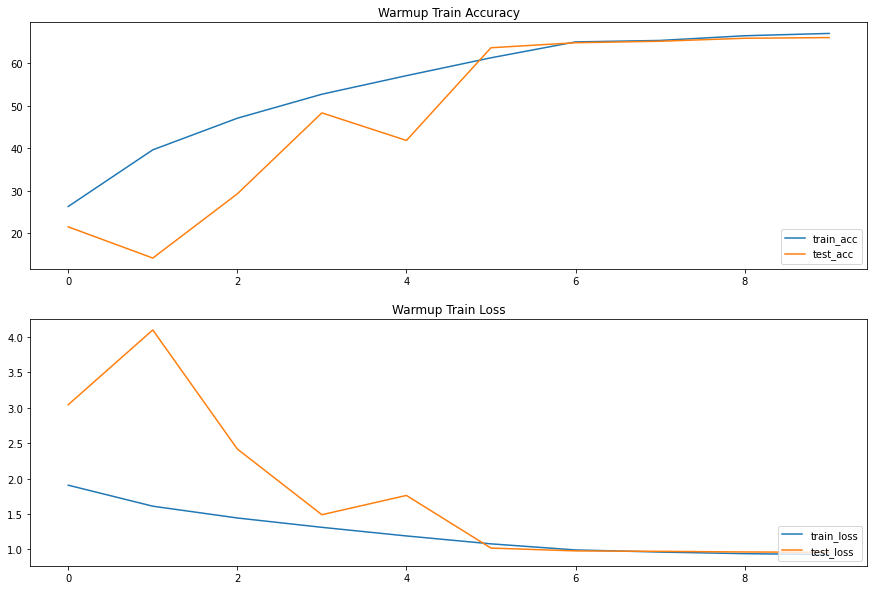

In [12]:
fig, axs = plt.subplots(2, figsize=(15,10))
axs[0].set_title('Warmup Train Accuracy')
axs[0].plot(training_accuracy,label='train_acc')
axs[0].plot(warmup_acc,label='test_acc')
axs[0].legend(loc='lower right')

axs[1].set_title('Warmup Train Loss')
axs[1].plot(training_loss,label='train_loss')
axs[1].plot(warmup_loss,label='test_loss')
axs[1].legend(loc='lower right')

In [13]:
# create psuedo-label for ulb data
def label(model):
    psuedolb = []
    model.eval()
    with torch.no_grad():
        for data, targets in ulb_loader:
            data = data.to(device)
            # targets = targets.to(device)
            outputs = model(data)
            _, predictions = torch.max(outputs, 1)
            predictions=predictions.cpu().numpy() # get np values of a tensor
            psuedolb.extend(predictions)
    return psuedolb

In [14]:
#create psusedo-lbl using trained model
chkpoint_dir = '../outputs/targeted_dl/0_8/checkpoint_warmup_train.pth'
checkpoint = torch.load(chkpoint_dir)

model.load_state_dict(checkpoint["model_state_dict"])

psuedolb = label(model)

print("Outputs count: ",len(psuedolb))
# df['Psuedo-lb'] = psuedolb

# train_df = pd.DataFrame({'img_idx':list(range(1,50001)), 'gt_label':gt_label}, columns=['img_idx', 'gt_label'])

labels = train_dataset.targets
new_labels = labels
print("Before update: ", len(new_labels))

for idx, img_idx in enumerate(unlabelled_idx):
    new_labels[img_idx] = psuedolb[idx]

print("After update: ", len(new_labels))

Outputs count:  39863
Before update:  50500
After update:  50500


In [15]:
class pseu_dataset(Dataset):
    def __init__(self, dataset, labels):
        self.dataset = dataset
        self.targets = labels
    
    def __getitem__(self, idx):

        image = self.dataset[idx][0]
        new_target = self.targets[idx]

        return (image, new_target)

    def __len__(self):
        return len(self.targets)

In [16]:
num_epochs = 200
epoch_ratio = 0.08
ulb_train_acc, ulb_train_loss = [], []
test_acc, test_loss = [], []

# reset learning rate
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 40, gamma = 0.1)

def shuffle_ulb():
    ulb_batch_idx = []

    # select from ulb_idx
    ulb_batch_idx = random.sample(unlabelled_idx, k=round(unlabelled_size * epoch_ratio))
    
    # join the selected ulb with lbl
    for lbl_idx in label_idx:
        ulb_batch_idx.append(lbl_idx)

    ulb_batch_idx = sorted(ulb_batch_idx)

    return ulb_batch_idx


def generate_psuedolbl():
    psuedolb = []
    # predict new psuedo-lbl for ulb dataset
    model.eval()
    with torch.no_grad():
        for data, targets in ulb_loader:
            data = data.to(device)
            # targets = targets.to(device)
            outputs = model(data)
            _, predictions = torch.max(outputs, 1)
            predictions=predictions.cpu().numpy() # get np values of a tensor
            psuedolb.extend(predictions)

    return psuedolb

def get_test_acc():
    model.eval()
    current_loss = 0
    epoch_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            _, predictions = torch.max(scores, 1)
            correct += (predictions == targets).sum().item()
            loss = criterion(scores, targets)
            current_loss += loss.item() * data.size(0)
            
    epoch_loss = current_loss / test_size
    test_epoch_acc = correct / test_size * 100
    test_loss.append(epoch_loss)
    test_acc.append(test_epoch_acc)

    return test_epoch_acc

def ulb_train(current_epoch, num_epoch, dataset):
    current_loss = 0.0
    current_corrects = 0

    ulb_batch_idx = shuffle_ulb()
    epoch_dataset = Subset(dataset, ulb_batch_idx)

    epoch_loader = DataLoader(
        epoch_dataset, batch_size=64, shuffle=True,
        num_workers=0, pin_memory=True,
    )

    model.train()

    loop = tqdm(enumerate(epoch_loader), total=len(epoch_loader)) # create a progress bar
    for batch_idx, (data, targets) in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model(data)
        
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(scores, 1)
        current_loss += loss.item() * data.size(0)
        current_corrects += (preds == targets).sum().item()
        loop.set_description(f"Epoch {current_epoch+1}/{num_epoch} process: {int((batch_idx / len(epoch_loader)) * 100)}")
        loop.set_postfix(loss=loss.data.item())
    
    # save model
    # final_acc = current_corrects / unlabelled_size * 100
    # ulb_train_acc.append(final_acc)
    epoch_losses =  current_loss / label_size
    training_loss.append(epoch_losses)

    if (current_epoch+1) % 10 == 0:
        torch.save({ 
            'model_state_dict': model.state_dict(), 
            'optimizer_state_dict': optimizer.state_dict(), 
            }, os.path.join(save_path, 'ulb_train_checkpoint_epoch_' + str(current_epoch+1)+'.pth'))

In [17]:
print("New batch size(including lbl): ", label_size+round(unlabelled_size * epoch_ratio))
# Initialize var
psuedolb = []
img_labels = new_labels

# load model
# model_dir = chkpoint_dir
# checkpoint = torch.load(model_dir)
# model.load_state_dict(checkpoint["model_state_dict"])

############### Start of main ulb training ######################
for current_epochs in range(num_epochs):
    train_correct = 0

    # Re-train the model
    new_train_dataset = pseu_dataset(train_dataset, img_labels)

    ulb_train(current_epochs, num_epochs, new_train_dataset)
    
    # Generate new label (Save to train_dataset)
    psuedolb = generate_psuedolbl()
    
    for idx, img_idx in enumerate(unlabelled_idx):
        img_labels[img_idx] = psuedolb[idx]
        
        if psuedolb[idx] == gt_labels[img_idx]:
            train_correct += 1

    final_acc = train_correct / unlabelled_size * 100
    ulb_train_acc.append(final_acc)

    # Get test_acc
    curr_test_acc = get_test_acc()

    print(" Train Acc:", final_acc, " Test Acc:", curr_test_acc)

New batch size(including lbl):  13439


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 60.22376639991972  Test Acc: 62.12


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 62.00988385219376  Test Acc: 63.739999999999995


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 64.37799463161328  Test Acc: 65.73


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 66.98943882798585  Test Acc: 67.43


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 67.4184080475629  Test Acc: 66.83


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 67.01452474725936  Test Acc: 67.30000000000001


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 65.65486792263503  Test Acc: 66.11


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 67.33562451396031  Test Acc: 68.16


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 71.3343200461581  Test Acc: 71.82


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 71.07342648571357  Test Acc: 71.00999999999999


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 72.25246469156862  Test Acc: 71.73


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 71.28163961568372  Test Acc: 71.54


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 72.80937209944058  Test Acc: 73.31


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 72.86456112184231  Test Acc: 73.83


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 73.91064395554776  Test Acc: 74.0


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 72.99751649399192  Test Acc: 73.29


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 74.99686426009082  Test Acc: 75.62


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 74.18909765948372  Test Acc: 73.96000000000001


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 75.38820460075759  Test Acc: 75.44


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 75.54122870832602  Test Acc: 75.07000000000001


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 74.7710909866292  Test Acc: 74.17


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 74.96425256503525  Test Acc: 75.02


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 74.87143466372326  Test Acc: 74.53999999999999


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 75.20256879813361  Test Acc: 74.59


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 76.80305044778366  Test Acc: 77.32


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 76.49449364071947  Test Acc: 76.64


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 75.51614278905251  Test Acc: 75.82


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 76.37909841206131  Test Acc: 76.99000000000001


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 77.2947344655445  Test Acc: 77.42999999999999


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 76.3640468604972  Test Acc: 76.41


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 76.4518475779545  Test Acc: 75.32


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 76.8883425733136  Test Acc: 76.85


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 77.78641848330533  Test Acc: 77.53


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 77.04638386473673  Test Acc: 76.46


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 77.834081729925  Test Acc: 78.11


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 77.49793041165994  Test Acc: 77.5


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 78.0347690841131  Test Acc: 78.22


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 77.86669342498055  Test Acc: 78.36999999999999


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 77.91686526352758  Test Acc: 78.13


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 77.80397862679678  Test Acc: 78.39


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 77.24957981085217  Test Acc: 77.53999999999999


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 76.91593708451447  Test Acc: 77.94


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 78.26806813335675  Test Acc: 78.63


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 77.94445977472844  Test Acc: 78.4


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 78.20535333517297  Test Acc: 78.55


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 78.87013019592104  Test Acc: 79.55


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 78.82999272508341  Test Acc: 79.39


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 77.98710583749342  Test Acc: 77.48


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 77.84662468956175  Test Acc: 78.42


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 77.90432230389082  Test Acc: 78.60000000000001


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 78.96796528108773  Test Acc: 79.60000000000001


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 78.50387577452776  Test Acc: 79.19


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.0106113438527  Test Acc: 79.7


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.3492712540451  Test Acc: 79.56


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 78.069889371096  Test Acc: 78.55


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 78.85257005242957  Test Acc: 78.97


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.0256628954168  Test Acc: 78.96


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 78.86511301206632  Test Acc: 78.8


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.07081755010913  Test Acc: 79.35


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.47720944234001  Test Acc: 79.56


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 78.22040488673707  Test Acc: 78.17


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 78.41607505707047  Test Acc: 78.93


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 78.70707172064321  Test Acc: 78.71000000000001


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.28153927200661  Test Acc: 79.58


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.12600657251086  Test Acc: 78.89


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.38690013295538  Test Acc: 79.60000000000001


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.2313674334596  Test Acc: 79.32000000000001


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.36933998946391  Test Acc: 79.32000000000001


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.48724381004942  Test Acc: 79.63


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.02817148734415  Test Acc: 78.67


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.53239846474173  Test Acc: 79.28


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.148583899857  Test Acc: 79.32000000000001


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.11346361287409  Test Acc: 79.33


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.77824047362215  Test Acc: 80.10000000000001


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.63525073376314  Test Acc: 79.89


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 77.96201991821991  Test Acc: 77.78


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.39442590873742  Test Acc: 79.41


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 78.90775907483129  Test Acc: 78.60000000000001


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.46968366655797  Test Acc: 79.53


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 78.77229511075433  Test Acc: 79.2


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.49226099390413  Test Acc: 79.71000000000001


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.58507889521611  Test Acc: 79.86999999999999


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.17710659007099  Test Acc: 79.96


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.37937435717332  Test Acc: 79.88


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.43707197150239  Test Acc: 79.45


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 78.65188269824148  Test Acc: 79.09


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.8735669668615  Test Acc: 79.83


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.80081780096832  Test Acc: 80.06


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.83593808795123  Test Acc: 79.71000000000001


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.02408248250256  Test Acc: 80.42


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.49727817775883  Test Acc: 79.35


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.90868725384442  Test Acc: 79.91


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.85098963951533  Test Acc: 79.74


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.16456363043424  Test Acc: 80.28999999999999


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 78.94789654566891  Test Acc: 79.31


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.7656975139854  Test Acc: 79.99000000000001


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.10686601610516  Test Acc: 79.91


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.0893058726137  Test Acc: 80.14


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.42545719087876  Test Acc: 80.36


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.95226149562251  Test Acc: 80.71000000000001


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.25487293981888  Test Acc: 80.07


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.52329227604545  Test Acc: 80.72


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.88954669743873  Test Acc: 80.58999999999999


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 79.9563505004641  Test Acc: 79.52


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.68635075132327  Test Acc: 79.95


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.67882497554123  Test Acc: 80.84


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.37872212327221  Test Acc: 81.3


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.83184908310966  Test Acc: 80.67999999999999


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.80676316383614  Test Acc: 80.58999999999999


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.81930612347288  Test Acc: 80.95


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.91964980056694  Test Acc: 80.91000000000001


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.02250206958834  Test Acc: 80.7


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.50824072448135  Test Acc: 80.03


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.63116172892155  Test Acc: 80.01


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.32009632993001  Test Acc: 80.15


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.79672879612674  Test Acc: 80.43


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.6186187692848  Test Acc: 80.04


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.2899932268018  Test Acc: 79.88


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.4078970473873  Test Acc: 80.4


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.48064621328048  Test Acc: 80.13


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.30597295737903  Test Acc: 81.03


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.29844718159697  Test Acc: 80.69


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.06765672428065  Test Acc: 80.43


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.75408273336177  Test Acc: 80.63


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.66377342397712  Test Acc: 80.04


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.2950104106565  Test Acc: 80.08


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.27336126232346  Test Acc: 81.04


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.12033715475503  Test Acc: 80.94


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.16298321752001  Test Acc: 80.86


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.11531997090033  Test Acc: 80.69


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.0400622130798  Test Acc: 80.41


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.16800040137471  Test Acc: 80.39


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.04507939693451  Test Acc: 80.61


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.95226149562251  Test Acc: 80.56


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.30346436545167  Test Acc: 80.85


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.9422271279131  Test Acc: 80.39


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.88703810551138  Test Acc: 80.33


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.87951232972932  Test Acc: 80.33


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.43641973760128  Test Acc: 80.9


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.97734741489602  Test Acc: 80.36


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.80927175576349  Test Acc: 80.57


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.3636705717081  Test Acc: 80.96


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.14542307402854  Test Acc: 80.84


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.22068083184908  Test Acc: 81.10000000000001


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.26834407846876  Test Acc: 80.65


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.23824097534053  Test Acc: 80.69


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.09023405162682  Test Acc: 80.73


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.92466698442165  Test Acc: 80.33


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.348619020144  Test Acc: 80.43


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.2658354865414  Test Acc: 80.9


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.52672904698592  Test Acc: 81.23


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.36617916363545  Test Acc: 80.73


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.01748488573364  Test Acc: 80.23


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.39377367483631  Test Acc: 80.86


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.19810350450292  Test Acc: 80.78


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.33607606050724  Test Acc: 80.74


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.12535433860974  Test Acc: 81.17


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.30597295737903  Test Acc: 80.97999999999999


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.44143692145599  Test Acc: 81.02000000000001


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.50164312771241  Test Acc: 81.06


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.07769109199006  Test Acc: 80.67


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.1579660336653  Test Acc: 80.91000000000001


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.8142889396182  Test Acc: 80.61


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.96731304718662  Test Acc: 80.36


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.95978727140456  Test Acc: 80.44


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.51167749542182  Test Acc: 81.08


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.59696962095177  Test Acc: 81.28999999999999


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.2658354865414  Test Acc: 80.80000000000001


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.37872212327221  Test Acc: 80.85


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.62205554022528  Test Acc: 81.15


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.30597295737903  Test Acc: 81.16


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.12033715475503  Test Acc: 81.12


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.07267390813536  Test Acc: 80.51


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 80.86947796201991  Test Acc: 80.80000000000001


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.31099014123373  Test Acc: 81.28999999999999


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.31851591701577  Test Acc: 81.35


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.67473597069964  Test Acc: 81.19


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.33607606050724  Test Acc: 81.03


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.65466723528084  Test Acc: 81.58


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.24576675112259  Test Acc: 81.16


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.67473597069964  Test Acc: 81.31


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.69982188997315  Test Acc: 81.88


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.56686651782354  Test Acc: 81.44


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.60700398866116  Test Acc: 81.47


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.584426661315  Test Acc: 81.28


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.76253668815694  Test Acc: 81.55


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.21064646413969  Test Acc: 80.69


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.74999372852018  Test Acc: 81.64


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.81270852670396  Test Acc: 81.57


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.44645410531068  Test Acc: 80.66


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.17050899330206  Test Acc: 80.56


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.21315505606704  Test Acc: 80.9


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.40882522640041  Test Acc: 80.94


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.95068108270827  Test Acc: 81.73


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.46401424880216  Test Acc: 81.35


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.52923763891327  Test Acc: 81.8


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.48157439229361  Test Acc: 81.01


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.81772571055866  Test Acc: 81.87


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 82.12126533376815  Test Acc: 81.75


  0%|          | 0/210 [00:00<?, ?it/s]

 Train Acc: 81.94064671499886  Test Acc: 81.76


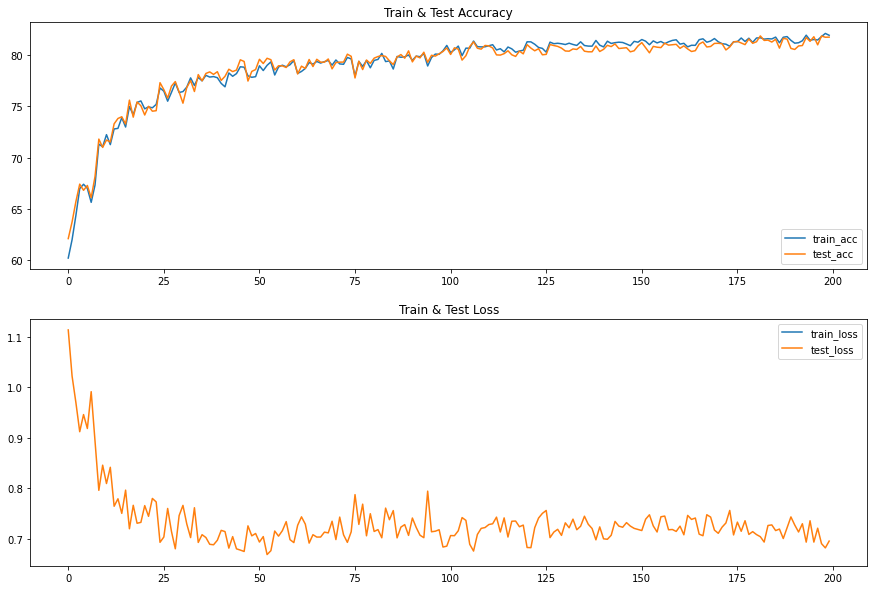

In [18]:
fig, axs = plt.subplots(2, figsize=(15,10))
axs[0].set_title('Train & Test Accuracy')
axs[0].plot(ulb_train_acc,label='train_acc')
axs[0].plot(test_acc,label='test_acc')
axs[0].legend(loc='lower right')

axs[1].set_title('Train & Test Loss')
axs[1].plot(ulb_train_loss,label='train_loss')
axs[1].plot(test_loss,label='test_loss')
axs[1].legend(loc='upper right')

In [19]:
top1_acc = max(test_acc)
best_model_state = test_acc.index(top1_acc)
top1_loss = test_loss[best_model_state]

#get train acc at that state
top1_train_acc = ulb_train_acc[best_model_state]

print("Top-1 Test Acc: ", top1_acc)
print("Loss: ", top1_loss)
print("Corresponding train acc: ", top1_train_acc)
print("Best model state: ", best_model_state)

Top-1 Test Acc:  81.88
Loss:  0.7043482864379883
Corresponding train acc:  81.69982188997315
Best model state:  181


In [20]:
bd_test_dir = '../inputs/bd-cifar10-multiclass/test/*.png'
all_images = glob.glob(bd_test_dir)
SRlist = []

transform = A.Compose([
    A.Resize(32, 32),
    A.Normalize(
    mean = [0.3403, 0.3121, 0.3214],
    std = [0.2724, 0.2608, 0.2669]
    ),
    ToTensorV2(),
    ])

ssl_pred = []

# load model
chkpoint_dir = '../outputs/targeted_dl/0_8/ulb_train_checkpoint_epoch_180.pth'
checkpoint = torch.load(chkpoint_dir)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

for i, image_path in enumerate(all_images):
    image = cv2.imread(image_path)
    orig_image = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = orig_image.shape

    # Apply the image transforms.
    image_tensor = transform(image=image)['image']
    # Add batch dimension.
    image_tensor = image_tensor.unsqueeze(0)
    # Forward pass through model.
    outputs = model(image_tensor.to(device))
    # Get the softmax probabilities.
    probs = F.softmax(outputs).data.squeeze()
    # Get the class indices of top k probabilities.
    class_idx = topk(probs, 1)[1].int()
    # Get the ground truth.
    image_name = image_path.split(os.path.sep)[-1]
    ssl_pred.append(class_idx.item())

C:\Users\65913\AppData\Local\Temp\ipykernel_1616\1833299638.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(outputs).data.squeeze()


In [21]:
atk_count = 0

for im in ssl_pred:
    if im == 4:
        atk_count += 1

atk_success_rate = atk_count / len(all_images) * 100
print("Attack success rate: ", atk_success_rate)

Attack success rate:  75.14999999999999
